<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png" align="center"/><br>



# What is JAX?

[JAX](https://github.com/google/jax) is a Python library designed for high-performance numerical computing, especially machine learning research. JAX has a NumPy like syntax and runs on the CPU, GPU, and TPU, with fast and efficient automatic differentiation suitable for high-performance computing and machine learning research.

JAX lets you just-in-time compile your own Python functions into XLA-optimized kernels using a one-function API. Compilation and automatic differentiation can be composed arbitrarily, so you can express sophisticated algorithms and get maximal performance while maintaining a NumPy like syntax.


References: 
- [DeepMind: Using JAX to accelerate our research](https://deepmind.com/blog/article/using-jax-to-accelerate-our-research)
- [DeepMind: Scientific advances, real world benefits](https://deepmind.com/impact)
- [GitHub Page of JAX](https://github.com/google/jax)

# Connections between JAX and NumPy

JAX uses XLA to compile and run your NumPy-like code on accelerators, i.e. GPUs and TPUs. Compilation happens under the hood by default, with library calls getting [just-in-time compiled](https://en.wikipedia.org/wiki/Just-in-time_compilation) and executed. 

We will talk about what the above mean as we progress in the tutorial. For now let's just see how we can perform some simple operations in JAX syntax.

References:
- [JAX As Accelerated NumPy](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)
- [How to Think in JAX](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)

In [1]:
import jax.numpy as jnp
import numpy as np
import jax

In [2]:
size = 3000
x = jnp.ones((100,100))
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

The slowest run took 1142.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 113 µs per loop


In [3]:
x = np.ones((100,100))
%timeit np.dot(x, x.T)

The slowest run took 41.41 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 105 µs per loop


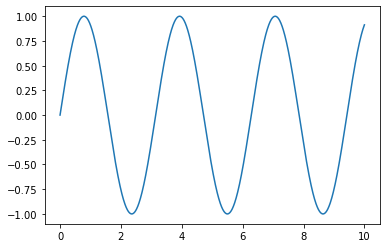

In [4]:
import matplotlib.pyplot as plt

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

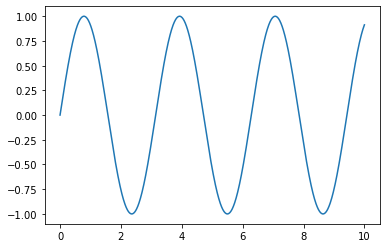

In [5]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

In [6]:
type(x_np)

numpy.ndarray

In [7]:
type(x_jnp)

jaxlib.xla_extension.DeviceArray


# Device Arrays 

It is the core array object in JAX. Some useful properties of the DeviceArray is that it is:

- Device agnostic, meaning we can run the same JAX code on CPUs, GPUs and TPUs.
- They are lazy, meaning the value of a DeviceArray is available only when requested.
- DeviceArray structure is immutable, meaning that it cannot be changed

Being device agnostic and lazy give JAX a huge advantage in code simplicity and computational speed.


References:
- [Useful tutorial that explains DeviceArray](https://github.com/AakashKumarNain/TF_JAX_tutorials/blob/main/src/notebooks/jax_tutorials/chapter_1_devicearray.ipynb)

- [JAX Documentation](https://jax.readthedocs.io/en/latest/)
- [JAX for the impatient](https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html)


**What does an immutable array mean?**

In [ ]:
x_jnp[0:10] = 0.1

If we need to assign new values to an array, we need to use the index_update function:

In [8]:
x_new = jax.ops.index_update(x_jnp, jax.ops.index[0:10], 0.1)

# Pure Functions

JAX transformation and compilation are designed to work only on Python functions that are functionally pure, meaning:



1.   When given identical inputs, the function returns identical outputs, (no variation with local [static variables](https://en.wikipedia.org/wiki/Static_variable), non-local variables, mutable reference arguments or input streams).
2.   The function cannot produce any [side effect](https://en.wikipedia.org/wiki/Side_effect_(computer_science)) (no mutation of local static variables, non-local variables, mutable reference arguments or input/output streams).

Here are some examples of functions that are not functionally pure for which JAX behaves differently than the Python interpreter. The behavior of these functions can be unexpected as it is not guaranteed by the JAX system.

References: 
- [Wikipedia](https://en.wikipedia.org/wiki/Pure_function)
- [Jax Documentation](https://jax.readthedocs.io/en/latest/index.html)

In [9]:
def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect (output stream).
  return x

impure_print_side_effect(4.)

Executing function


4.0

In [10]:
def impure_uses_append(x):
    x.append(sum(x)) # This is a side-effect (mutating the function argument).
    return x

impure_uses_append([1.,2.,3.])

[1.0, 2.0, 3.0, 6.0]

In [11]:
global_variable = 1.
def impure_uses_global(x):
    global global_variable 
    global_variable += 1 # This is a side-effect (mutating a non-local variable).
    return x

impure_uses_global(4.)

4.0

**But why does JAX require functionally pure Python functions?**

To answer this question, we need to first understand some of internal workings of JAX. Let's start by talking about Jaxprs (JAX expressions).

# The Jaxpr Intermediate Language

In the previous section, we discussed that JAX allows us to transform Python functions. This is done by first converting the Python function into a simple intermediate language called jaxpr. The transformations then work on the jaxpr representation. 

References:
- [Understanding Jaxprs](https://jax.readthedocs.io/en/latest/jaxpr.html)
- [JAX: The Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)
- [Just In Time Compilation with JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/02-jitting.ipynb)

# Jaxpr for pure functions

A jaxpr instance represents a function with a number of variables as inputs and a number of resulting variables. The inputs and outputs have types, which in JAX are represented as abstract values. 

Let's first define a function that will help us visualize the Jaxpr process:




In [12]:
import jax
from jax import core
from graphviz import Digraph
import itertools

styles = {
  'const': dict(style='filled', color='goldenrod1'),
  'invar': dict(color='mediumspringgreen', style='filled'),
  'outvar': dict(style='filled,dashed', fillcolor='indianred1', color='black'),
  'op_node': dict(shape='box', color='lightskyblue', style='filled'),
  'intermediate': dict(style='filled', color='cornflowerblue')
}

def _jaxpr_graph(jaxpr):
    id_names = (f'id{id}' for id in itertools.count())
    graph = Digraph(engine='dot')
    graph.attr(size='6,10!')
    for v in jaxpr.constvars:
        graph.node(str(v), core.raise_to_shaped(v.aval).str_short(), styles['const'])
    for v in jaxpr.invars:
        graph.node(str(v), v.aval.str_short(), styles['invar'])
    for eqn in jaxpr.eqns:
        for v in eqn.invars:
            if isinstance(v, core.Literal):
                graph.node(str(id(v.val)), core.raise_to_shaped(core.get_aval(v.val)).str_short(), styles['const'])
        if eqn.primitive.multiple_results:
            id_name = next(id_names)
            graph.node(id_name, str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), id_name)
            for v in eqn.outvars:
                graph.node(str(v), v.aval.str_short(), styles['intermediate'])
                graph.edge(id_name, str(v))
        else:
            outv, = eqn.outvars
            graph.node(str(outv), str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), str(outv))
    for i, v in enumerate(jaxpr.outvars):
        outv = 'out_'+str(i)
        graph.node(outv, outv, styles['outvar'])
        graph.edge(str(v), outv)
    return graph


def jaxpr_graph(fun, *args):
    jaxpr = jax.make_jaxpr(fun)(*args).jaxpr
    return _jaxpr_graph(jaxpr)


def grad_graph(fun, *args):
    _, fun_vjp = jax.vjp(fun, *args)
    jaxpr = fun_vjp.args[0].func.args[1]
    return _jaxpr_graph(jaxpr)

Now let's see how Jaxpr works for a simple example:

In [13]:
from jax import make_jaxpr
import jax.numpy as jnp
def func(first_arg, second_arg):
   out = first_arg + jnp.sin(second_arg) * 3.
   return out

first_arg, second_arg = jnp.zeros(8), jnp.ones(8)
print(make_jaxpr(func)(first_arg, second_arg))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
  in (e,) }


Here a and b are the input variables and they correspond to first and second function arguments, respectively. The variables c and d are intermediate parameters and e the result.

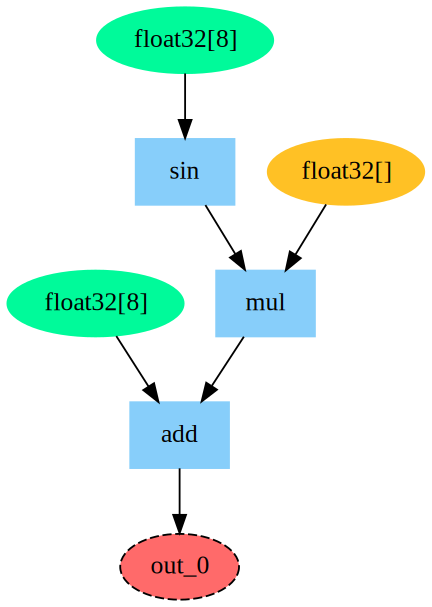

In [14]:
g = jaxpr_graph(func, first_arg, second_arg)
g

# Jaxpr for impure functions

Let's see how the case of an impure function that appends to a globally defined list is translated to Jaxpr:

In [15]:
global_list = []

def func(first_arg, second_arg):
   global_list.append(first_arg)
   out = first_arg + jnp.sin(second_arg) * 3.
   return out

first_arg, second_arg = jnp.zeros(8), jnp.ones(8)
print(make_jaxpr(func)(first_arg, second_arg))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
  in (e,) }


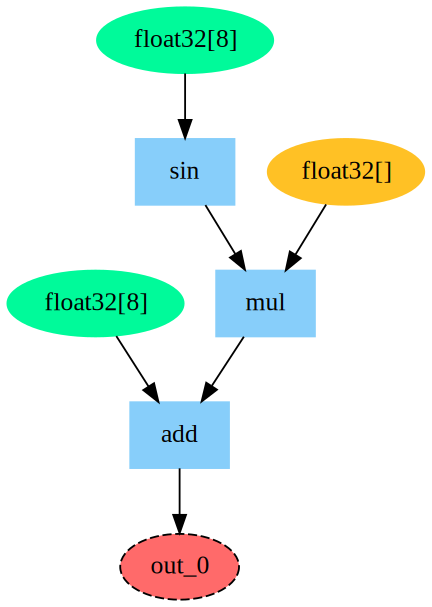

In [16]:
g = jaxpr_graph(func, first_arg, second_arg)
g

See that there is no process the above corresponding to the side-effect. This is a design feature of Jax. 

**NOTE: We can define and run impure functions in JAX but there is no guarantee how they will behave once translated to Jaxpr**

# Function Transformations in JAX

JAX not only provides us with a NumPy-like syntax, but also with composable transormations that can be very useful when designing machine learning methods. In this tutorial, we will talk about three of the most basic ones:

* JIT-compilation: This feature allow us to just-in-time compile (XLA) and execute our program on a hardware accelarators with minimal modifications in our code. This is very useful to scale applications without being an expert in high-performance computing. 

* Automatic Vectorization: This feature allows us to automatically transform a a function that works for a single input to a function that works for a vector of inputs (batching). Moreover, JAX allows data parallelization to multiple hardware accelarators.

* Differentiation: This feature allows us to perform forward and reverse mode automatic differentiation of arbitrary functions, which is very useful in optimizing Machine Learning models via gradient-based optimizaition. 


References:
- [Tutorial - Automatic Vectorization in JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/03-vectorization.ipynb#scrollTo=zMIrmiaZxiJC)
- [Tutorial - Autodiff Cookbook](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/autodiff_cookbook.ipynb)
- [Tutorial - Just In Time Compilation with JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/02-jitting.ipynb)
- [JAX Documentation](https://jax.readthedocs.io/en/latest/index.html)

- [JIT Compilation Explained](https://www.freecodecamp.org/news/just-in-time-compilation-explained/)

In [17]:
from jax import jit, grad, vmap
import numpy as np

##  Just In Time Complilation

Let's take the *Scaled Exponential Linear Unit*
([SELU](https://proceedings.neurips.cc/paper/6698-self-normalizing-neural-networks.pdf)) activation function as an example:

In [18]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

The slowest run took 30.64 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.67 ms per loop


Let's use the jit decorator for the SELU function and see how jit can speed-up its application:



In [19]:
# Define selu_jit as the compiled version of selu.
selu_jit = jax.jit(selu)

# Warm up
''' We ran `selu_jit` once on `x`. This is where JAX does its tracing -- it needs
 to have some inputs to wrap in tracers, after all. The jaxpr is then compiled 
 using XLA into very efficient code optimized for your GPU or TPU. Subsequent
 calls to `selu_jit` will now use that code, skipping our old Python 
 implementation entirely. '''
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

1000 loops, best of 5: 1.18 ms per loop


***NOTE: JIT usually saves time when the compiled function is complex and we use it many times, i.e. optimizatoins step in your training loop. Ideally, we would want to jit as much code as possible, i.e. the entire update step.***

**CAREFUL:**
* **JIT compilation requires all arrays to have static shapes,**
* **JIT compilation is agnostic to the content of the array, so control flow statements might fail.**

## Automatic Vectorization in JAX

Another very useful feature of JAX is the automatic vectorization. This transform converts a function that runs for a single example to a function that can operate on many examples at the same time, thus alleviating the need for for-loops or making the use of batches in machine learning more natural.

Refereces: 
- [Automatic Vectorization in JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/03-vectorization.ipynb#scrollTo=zMIrmiaZxiJC)

- [Useful tutorial on vmap and pmap](https://github.com/AakashKumarNain/TF_JAX_tutorials/blob/main/src/notebooks/jax_tutorials/chapter_5_vmap_pmap.ipynb)


Let's consider the function:

In [20]:
import numpy as np

def f(x):
  return jnp.tanh(x)

For which we want to compute its first derivative using central finite differences in the domail [- $\pi$, $\pi$] using $n=500$ function samples: 

In [21]:
x = np.linspace(-jnp.pi, jnp.pi, 500)
dx = x[1] - x[0]
fin_diff = lambda x: (f(x + dx) - f(x - dx)) / (2.0 * dx)

Now we could compute the derivative of the ``jnp.tanh`` function using the $n$ by employing a for loop:

In [22]:
fd_loop = np.zeros(x.shape)
for i in range(x.shape[0]):
  fd_loop[i] = (f(x[i] + dx) - f(x[i] - dx)) / (2.0 * dx)

Another way to perform the same operation would be by using the automatic vectorization function transform of JAX:

In [23]:
fd_vmap = vmap(fin_diff)(x)

Let's check the maximum error between these two results:

In [24]:
jnp.max(fd_vmap - fd_loop)

DeviceArray(7.122755e-06, dtype=float32)

## Computing Gradients in JAX

The last very useful transform that we will consider is `jax.grad`, which takes a function and returns a new function that computes the gradient of the original function. 

Let's see it's use by considering a simple exaple of a function that takes a scalar and returns its square:


In [25]:
def square(x):
  return x**2

def dx_square(x):
  return 2.*x 

sqr_grad = grad(square)(4.0)
analytic_der = dx_square(4.0)

Now let's print the error between the analytic and the jax derivative evaluations:

In [26]:
sqr_grad - analytic_der

DeviceArray(0., dtype=float32)

Applying `jax.grad` to `sum_squared_error` will return a different function, namely the gradient of `sum_squared_error` with respect to its first parameter `x`. 

# Composing transformations

The function Transformation discribed above can be combined together in a straigth forward manner:

Text(0.5, 1.0, 'Comparison with finite differences')

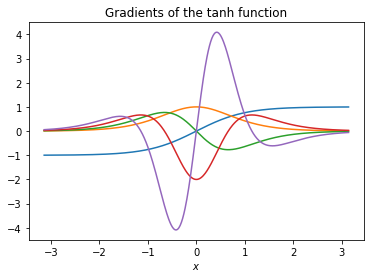

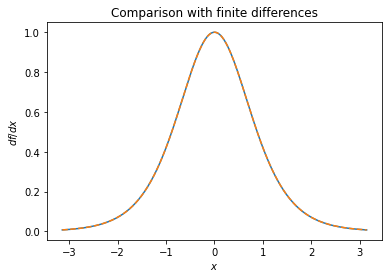

In [27]:
import matplotlib.pyplot as plt

@jit
def f(x):
  return jnp.tanh(x)

x = np.linspace(-np.pi, np.pi, 500)

# Tip: define functions to operate on a single data-point, then use 'vmap' to vectorize them!
plt.figure(1)
plt.plot(x, vmap(f)(x))
plt.plot(x, vmap(grad(f))(x))
plt.plot(x, vmap(grad(grad(f)))(x))
plt.plot(x, vmap(grad(grad(grad(f))))(x))
plt.plot(x, vmap(grad(grad(grad(grad(f)))))(x))
plt.xlabel('$x$')
plt.title("Gradients of the tanh function")

# Compare against centered finite differences
dx = 1e-3
fin_diff = lambda x: (f(x + dx) - f(x - dx)) / (2.0 * dx)
fd_approx = vmap(fin_diff)(x)

plt.figure(2)
plt.plot(x, vmap(grad(f))(x))
plt.plot(x, fd_approx, '--')
plt.xlabel('$x$')
plt.ylabel('$df/dx$')
plt.title("Comparison with finite differences")


# Pseudo Random Numbers in JAX

Even thought JAX has a syntax that is similar to NumPy in most cases, the pseudo random number generation (PRNG) is a notable exception. 

The PRNG-generated random numbers and sequences depend on an initial value, the `seed` and each random sampling step is a deterministic function of some `state` that is passed from a sample to the next.

In this section, we will introduce the basics of `jax.random` library for generating random number in a reproducible, parallelizable and vectorisable way.

References:

- [Pseudo Random Numbers in JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05-random-numbers.ipynb)

Following the philosophy of the functional programming, JAX does not use a global state. Instead, random functions are used to explicitly define the state, which is referred to as a `key` .

In [28]:
from jax import random

key = random.PRNGKey(12)

print(key)

[ 0 12]


A key is an array of 2 elements that represents a 'random seed'.

However, instead of setting it once as in NumPy, any call of a random function in JAX requires a key to be specified. Random functions consume the key, but do not modify it. Feeding the same key to a random function will always result in the same sample being generated:

In [29]:
print(random.normal(key))
print(random.normal(key))

-0.5135873
-0.5135873




**NOTE: Never reuse keys (unless you want identical outputs).**

In order to avoid identical outputs, we need to `split` the key whenever a random funciton is called. For example:

In [30]:
new_key, subkey = random.split(key)
normal_sample = random.normal(subkey)
normal_sample

DeviceArray(0.7359279, dtype=float32)

`split` converts one `key` into several independent keys. As in the handle states section, `split` returns a new state, called the `new_key`, which can be then used to genererate more `subkeys` using `split` and `subkeys` that can be used as input states to functions of the `random` library.

**NOTE: Splite the keys as many times as the samples you want to draw from the distribution.**

**NOTE: It doesn't really matter which output we call key and which subkey.**


`split()` can create as many keys as you need. For example:

In [31]:
key, *subkeys = random.split(key, num=4)

In [32]:
subkeys

[array([4225435153, 1890659353], dtype=uint32),
 array([2404881503,  816097510], dtype=uint32),
 array([417843976, 130150937], dtype=uint32)]

# Pytrees and an example of an MLP


Pytrees are nested structures , i.e. lists of lists, that JAX supports via its `jax.tree_utils` library. 

Pytrees are common in machine learning for representing model parameters or data entries. 

Let's consider the following example of a simple MLP to explain Pytrees and see how they become useful:

In [33]:
import numpy as np

def MLP(layers, activation=jax.nn.relu):
    ''' Vanilla MLP'''
    def init(rng_key):
        key, *keys = jax.random.split(rng_key, len(layers))
        # Here we define the parameters of the model as a Pytree.
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = jnp.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(inputs, W) + b
        return outputs
    return init, apply

# Initialize the parameters of the neural network.
def init_layer(key, d_in, d_out):
    k1, k2 = jax.random.split(key)
    glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
    W = glorot_stddev * jax.random.normal(k1, (d_in, d_out))
    b = jnp.zeros(d_out)
    return W, b
  
key = jax.random.PRNGKey(1000)
init, apply  = MLP([1,32,32,1])
params = init(jax.random.PRNGKey(1000))


xs = np.random.normal(size=(512, 1))
ys = xs ** 2

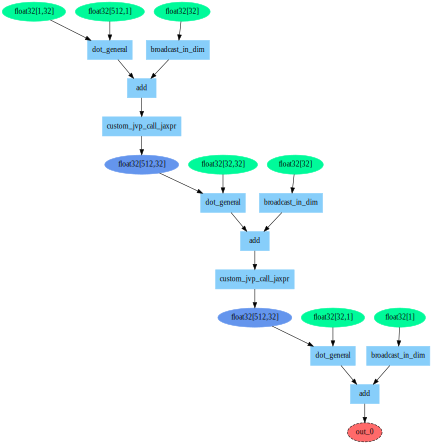

In [34]:
g = jaxpr_graph(apply, params, xs)
g

In [35]:
apply = jax.jit(apply)

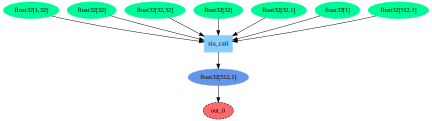

In [36]:
g = jaxpr_graph(apply, params, xs)
g

Let's define the necessary functions to train the neural network, i.e. the forward pass, the loss and the update functions.

In [37]:
def loss_fn(params, x, y):
  return jnp.mean((apply(params, x) - y) ** 2)

@jax.jit
def update(params, x, y):
  LEARNING_RATE = 0.001
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_multimap(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

Define the training loop and the input dataset:

In [38]:
import matplotlib.pyplot as plt

for _ in range(10000):
  params = update(params, xs, ys)


Plot the results:

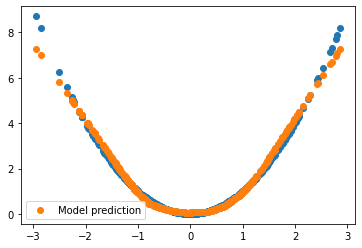

In [39]:
plt.scatter(xs, ys)
plt.scatter(xs, apply(params, xs), label='Model prediction')
plt.legend()

# An example of Image-2-Image regression using JAX.

We will apply what we discussed above to the case of image2image regression for a simple Darcy flow problem.

For implementing img2img and the other models in this series of tutorials, we will need:

* Import libraries that we are going to use.
* Define the model architecture.
* Define the data generating class that will fetch mini-batches during training.
* Define a class that will handle the training, the model initialization and all auxiliary functions needed to train the model.
* Define a function that will read and preprocess the training and testing data.
* Define the main function body that will handle all the above processes.

First let's import libraries that we are going to use:


# Predicting flow through a porous medium

Fluid flow through porous media is governed by Darcy's Law, which can be mathematically expressed by the following partial differential equation system,
$$ \nabla \cdot ( u_0(x) \nabla s(x)) = f(x), \quad x \in \mathcal{X},$$
subject to appropriate boundary conditions

$$ s = 0   \quad \text{on} \quad \Gamma_\mathcal{X},$$ 
$$(u_0(x)  \nabla  s(x)) \cdot n = g  \quad \text{ on } \Gamma_N, $$
where $u$ is permeability of the porous medium, and $s$ is the corresponding fluid pressure. Here we consider a domain $\mathcal{X} = [0,1] \times [0,1]$ with a Dirichlet boundary  $\Gamma_D = \{ (0,x) \cup (1,x)\;|\;x_2 \in [0,1] \subset \partial \mathcal{X} \}$, and a Neumann boundary $\Gamma_N = \{ (x,0) \cup (x,1) \;|\;x \in [0,1]\subset \partial \mathcal{X} \}$. 

For a given forcing term $f$ and set of boundary conditions, the approximate solution of system maps the permeability function $u(x)$, for the chosen grid, to the fluid pressure function $s(x)$, on the same grid. 

We set the Neumann boundary condition to be $g(x) = \sin(5x)$, the forcing term $f(x) = 5 \exp( - ((x_1-0.5)^2 + (x_2-0.5)^2))$, and sample the permeability function $u(x)$ from a Gaussian measure, as $u_0(x) = \exp(u \cos(x))$ with $u \sim \mathcal{N}(0, 7^{3/2}(- \Delta + 49 I)^{-1.5}$. The training and testing data sets are constructed by sampling the initial condition along a $N_x \times N_y$ grid and solving the forward problem with the Finite Element library, Fenics. This gives us access to $N_x \times N_y$ solution values to use for training different operator learning models.

For the case, presented we consider $N_x = N_y =256$ which we then subsample to get different resolutions for the input and output functions.


<img src="
https://github.com/PredictiveIntelligenceLab/TRIPODS_Winter_School_2022/raw/main/img2img.png" align="center"/><br>

In [40]:
import jax.numpy as jnp
from jax.example_libraries import stax
from jax import random, grad, vjp, jit
from jax.numpy.linalg import norm
from jax.example_libraries.stax import Conv, ConvTranspose, BatchNorm, Relu
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
import jax

import numpy as np

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import matplotlib.pyplot as plt

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next let's define the encoder and decoder architectures using the built-in library `stax`. 

In [42]:
def Encoder():
    init, apply = stax.serial(
                              Conv(16, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(), 
                              Relu,
                              Conv(32, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(),
                              Relu,
                              Conv(64, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(),
                              Relu,
                              Conv(128, (4, 4), (2, 2), padding="SAME")
                              )
    return init, apply

def Decoder():
    init, apply = stax.serial(
                              ConvTranspose(128, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(), 
                              Relu,
                              ConvTranspose(64, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(),
                              Relu,
                              ConvTranspose(32, (4, 4), (2, 2), padding="SAME"),
                              BatchNorm(), 
                              Relu,
                              ConvTranspose(1, (4, 4), (2, 2), padding="SAME"),
                              )
    return init, apply

Now we need to create some data generating class that will handle mini-batching for the training process.

In [43]:
class DataGenerator(data.Dataset):
    def __init__(self, inputs, targets, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.inputs = inputs
        self.targets = targets
        self.N = targets.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, inputs, targets):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = inputs[idx,...]
        targets = targets[idx,...]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.inputs, self.targets)
        return inputs, targets

Now we define a class that contains the main body of the process of image-2-image regression. 

In [44]:
class img2img:
    # Initialize the class
    def __init__(self, res, init_key=random.PRNGKey(0)):
        # Define encoder and decoder networks
        self.encoder_init, self.encoder_apply = Encoder()
        self.decoder_init, self.decoder_apply = Decoder()
        
        # Initialize parameters
        k1, k2 = random.split(init_key, 2)
        out_dim, encoder_params = self.encoder_init(k1, (-1, res, res, 1))
        _, decoder_params = self.decoder_init(k2, out_dim)
        params = (encoder_params, decoder_params)
        _, self.unravel = ravel_pytree(params)
        
        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=0.99)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        
        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        
    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        encoder_params, decoder_params = params
        inputs, targets = batch
        inputs = self.encoder_apply(encoder_params, inputs)
        outputs = self.decoder_apply(decoder_params, inputs)
        loss = np.mean((targets-outputs)**2)
        return loss
    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 100 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        encoder_params, decoder_params = params
        inputs = self.encoder_apply(encoder_params, inputs)
        outputs = self.decoder_apply(decoder_params, inputs)
        return outputs
        
    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])

Now we can define the training parameters

In [45]:
# Load data
ntrain = 5000
ntest  = 5000
s = 256
sub = 4
h = s//sub
Train = False

if Train:
    d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/train_darcy_dataset.npz")
    X_train   = d["U_train"].reshape(ntrain,s, s)[:,::sub,::sub,None]
    Y_train   = d["s_train"].reshape(ntrain,s, s)[:,::sub,::sub,None]
    dataset = DataGenerator(X_train, Y_train, batch_size = 100)


d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/test_darcy_dataset.npz")
X_test   = d["U_test"].reshape(ntest,s,s)[:,::sub,::sub,None]
Y_test   = d["s_test"].reshape(ntest,s,s)[:,::sub,::sub,None]

del d

res = X_test.shape[1]

Let's plot an input and an output of the model:

Text(0.5, 1.0, '$Output$')

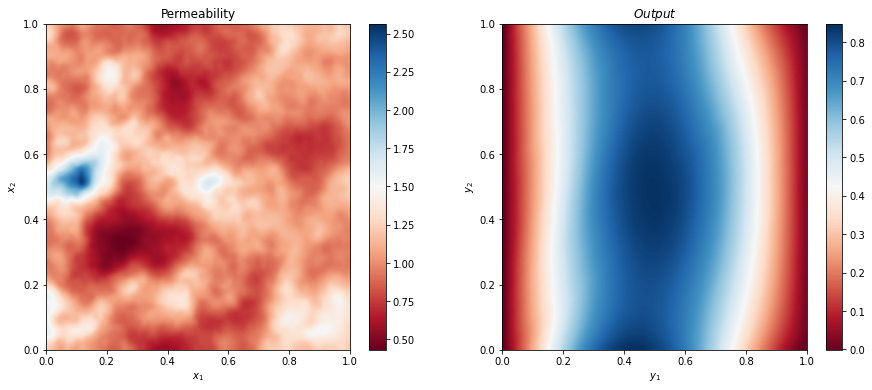

In [47]:
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
axs = _axs.flatten()
 
ax1 = axs[0]
ax2 = axs[1]

ux = jnp.exp(X_test[0,:,:,0]*jnp.cos(jnp.linspace(0,1,X_test.shape[1])))

# Plot 1
cntr1 = ax1.imshow(ux, cmap='RdBu', vmin=ux.min(), vmax=ux.max(),
                    extent=[0,1,0,1],
                    interpolation='quadric', origin='lower', aspect='auto')
fig.colorbar(cntr1, ax=ax1)
ax1.set(xlim=(0, 1), ylim=(0, 1))
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax1.set_title("Permeability")

# Plot 2
cntr2 = ax2.imshow(Y_test[0,:,:,0], cmap='RdBu', vmin=Y_test[0,:,:,0].min(), vmax=Y_test[0,:,:,0].max(),
      extent=[0,1,0,1],
      interpolation='quadric', origin='lower', aspect='auto')
fig.colorbar(cntr2, ax=ax2)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_xlabel("$y_1$")
ax2.set_ylabel("$y_2$")
ax2.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax2.set_title("$Output$")


Let's count the model parameters:

In [48]:
# Initialize img2img regression model
model = img2img(res)
model.count_params()

The number of model parameters is: 599921


Let's train the model for some iterations (optional because we can load parameters)

In [49]:
if Train:
    model.train(dataset, nIter=50000)

flat_params = np.load('/content/drive/MyDrive/Tripods_Winter_School_2022/img2img_parameters_%dx%d.npy'%(h,h))
opt_params = model.unravel(flat_params)

We can now make predictions

In [50]:
if Train:
    opt_params = model.get_params(model.opt_state)

Y_pred = model.predict(opt_params, X_test)

And finally compute the error vector

In [51]:
error = []
for i in range(0,ntrain):
    error.append(norm(Y_test[i,:,:].flatten() - Y_pred[i,:,:].flatten(),2)/norm(Y_test[i,:,:].flatten(),2))
print("The average test u error is %e the standard deviation is %e the min error is %e and the max error is %e"%(np.mean(error),np.std(error),np.min(error),np.max(error)))

The average test u error is 1.261780e-02 the standard deviation is 4.682725e-03 the min error is 4.651347e-03 and the max error is 4.365892e-02


In [52]:
# Save trained model parameters
saveParameters = False
if saveParameters:
    opt_params_flat, _ = ravel_pytree(opt_params)
    np.save("img2img_parameters_%dx%d.npy"%(h,h), opt_params_flat)

# END OF THE FIRST TUTORIAL